# Task 1: FedSGD vs Centralized
In this task, you will study the theoretical equivalence between FedSGD and centralized training in a controlled
scenario — with no averaging, no mini-batches, and full gradient descent (GD) steps. \\
Your task is to identify and correct any mistakes that prevent the gradients from being similar in both scenarios.
If you believe that FedSGD and Centralized training should not be equivalent, provide a reasoned argument to
support your view.

In [8]:
#Importing Libraries
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [9]:
#Loading Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()

In [10]:
#Function to partition data
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [13]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}

    return overall_update

In [14]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()

        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates

In [15]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [16]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

Using device: cpu
Epoch 1/4


Training Batches (Epoch 1): 100%|██████████| 48000/48000 [06:46<00:00, 118.14it/s, loss=2.26]


Epoch 1 Update Sum: 220.73557338118553
Epoch 2/4


Training Batches (Epoch 2): 100%|██████████| 48000/48000 [06:27<00:00, 123.94it/s, loss=2.32]


Epoch 2 Update Sum: 260.1212306767702
Epoch 3/4


Training Batches (Epoch 3): 100%|██████████| 48000/48000 [06:25<00:00, 124.66it/s, loss=2.16]


Epoch 3 Update Sum: 1191.705442726612
Epoch 4/4


Training Batches (Epoch 4): 100%|██████████| 48000/48000 [06:23<00:00, 125.14it/s, loss=109]


Epoch 4 Update Sum: 128299.36974716187


In [17]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

Using device: cpu
Round 1/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7296/7296 [00:58<00:00, 124.96it/s, loss=2.26]


Client 1 Update Sum at Round 1: 121.86750912666321
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 8293/8293 [01:09<00:00, 119.56it/s, loss=2.26]


Client 2 Update Sum at Round 1: 189.9154573082924
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12045/12045 [01:38<00:00, 122.23it/s, loss=2.26]


Client 3 Update Sum at Round 1: 149.394489582628
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7532/7532 [01:01<00:00, 122.76it/s, loss=2.25]


Client 4 Update Sum at Round 1: 133.2356148213148
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12834/12834 [01:51<00:00, 115.10it/s, loss=2.26]


Client 5 Update Sum at Round 1: 201.83187703043222
Averaged Update Sum at Round 1: 220.7355706244707
Round 2/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7296/7296 [01:03<00:00, 115.30it/s, loss=2.31]


Client 1 Update Sum at Round 2: 141.32352187484503
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 8293/8293 [01:07<00:00, 123.77it/s, loss=2.33]


Client 2 Update Sum at Round 2: 209.61420944333076
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12045/12045 [01:38<00:00, 122.53it/s, loss=2.3]


Client 3 Update Sum at Round 2: 175.60999622941017
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7532/7532 [01:03<00:00, 119.09it/s, loss=2.3]


Client 4 Update Sum at Round 2: 148.03822687268257
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12834/12834 [01:44<00:00, 122.83it/s, loss=2.32]


Client 5 Update Sum at Round 2: 229.9308662712574
Averaged Update Sum at Round 2: 260.1218373030424
Round 3/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7296/7296 [01:01<00:00, 119.34it/s, loss=2]


Client 1 Update Sum at Round 3: 484.3801489472389
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 8293/8293 [01:11<00:00, 116.73it/s, loss=2.19]


Client 2 Update Sum at Round 3: 609.4695796072483
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12045/12045 [01:47<00:00, 112.53it/s, loss=2.01]


Client 3 Update Sum at Round 3: 486.9635393321514
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7532/7532 [01:00<00:00, 123.54it/s, loss=2.1]


Client 4 Update Sum at Round 3: 446.6628428399563
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12834/12834 [01:47<00:00, 119.58it/s, loss=2.16]


Client 5 Update Sum at Round 3: 836.8077808022499
Averaged Update Sum at Round 3: 1191.6950244903564
Round 4/4
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7296/7296 [00:59<00:00, 122.23it/s, loss=92.3]


Client 1 Update Sum at Round 4: 18549.010424137115
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 8293/8293 [01:01<00:00, 134.09it/s, loss=77.8]


Client 2 Update Sum at Round 4: 25392.019007205963
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12045/12045 [01:31<00:00, 132.10it/s, loss=114]


Client 3 Update Sum at Round 4: 39244.53829598427
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 7532/7532 [00:59<00:00, 126.08it/s, loss=86.2]


Client 4 Update Sum at Round 4: 23429.020433187485
Epoch 1/1 for local client


Training Batches (Epoch 1): 100%|██████████| 12834/12834 [01:42<00:00, 124.66it/s, loss=109]


Client 5 Update Sum at Round 4: 22957.984291434288
Averaged Update Sum at Round 4: 128300.82976913452


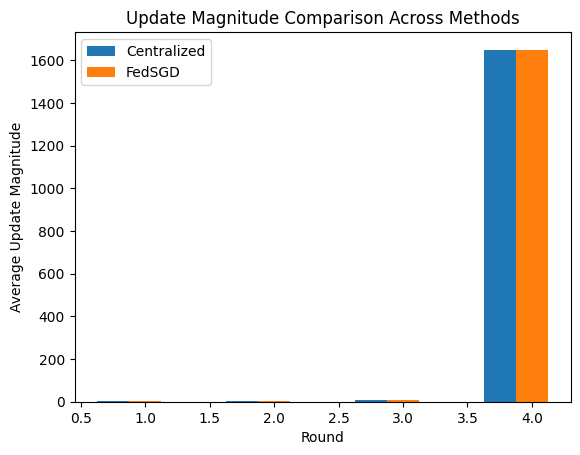

Success! The gradients are approximately the same.


In [18]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")